In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder , StandardScaler , MinMaxScaler , RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import recall_score



### Read Data

In [3]:

diabetes = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
diabetes.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### Remove Outliers

In [ ]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

diabetes_cleaned = drop_outliers_iqr(diabetes, 'BMI')
diabetes_cleaned = drop_outliers_iqr(diabetes_cleaned, 'GenHlth')

### Remove Correlated Columns

In [ ]:
# vif_data = pd.DataFrame()
# diabetes_copy = diabetes_cleaned.copy()
# diabetes_copy.drop(columns=['Diabetes_binary'], inplace=True)
# vif_data['Feature'] = diabetes_copy.columns
# vif_data['VIF'] = [variance_inflation_factor(diabetes_copy.values, i) for i in range(diabetes_copy.shape[1])]
# print(vif_data)

In [ ]:
diabetes_cleaned = diabetes_cleaned.drop(columns=['CholCheck','AnyHealthcare','Education'])

### Split Data

In [ ]:

x_train, x_test = train_test_split(diabetes_cleaned, test_size=0.20, random_state=42)
x_test,y_test = x_test.drop(['Diabetes_binary'],axis=1),x_test['Diabetes_binary']
x_train,y_train = x_train.drop(['Diabetes_binary'],axis=1),x_train['Diabetes_binary']


### Standardize Data

In [ ]:
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = StandardScaler()

scaler.fit(x_train)
x_train_scaler = scaler.transform(x_train)
x_test_scaler = scaler.transform(x_test)

### Search For Best Parameters Wit Cross-Validation with Smothing

In [ ]:

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaler, y_train)

recall_class1_scorer = make_scorer(
    recall_score, 
    pos_label=1,
    average='binary'
)

logistic = LogisticRegression(random_state=42)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'solver': ['liblinear', 'saga']
    },
    {
        'penalty': ['l2', 'l1'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'class_weight': ['balanced', {0:1, 1:6}], 
        'solver': ['liblinear', 'saga']
    }
]

grid_search = GridSearchCV(
    logistic, 
    param_grid, 
    cv=5, 
    scoring=recall_class1_scorer,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(x_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_scaler)

print("Best Parameters:", grid_search.best_params_)
print("\nTest Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))


NameError: name 'SMOTE' is not defined

### TEST 1 USE Smothing

Training Accuracy: 74.89%
Test Accuracy: 72.79%
              precision    recall  f1-score   support

 No Diabetes       0.96      0.72      0.82     40903
    Diabetes       0.28      0.77      0.41      5689

    accuracy                           0.73     46592
   macro avg       0.62      0.75      0.62     46592
weighted avg       0.87      0.73      0.77     46592



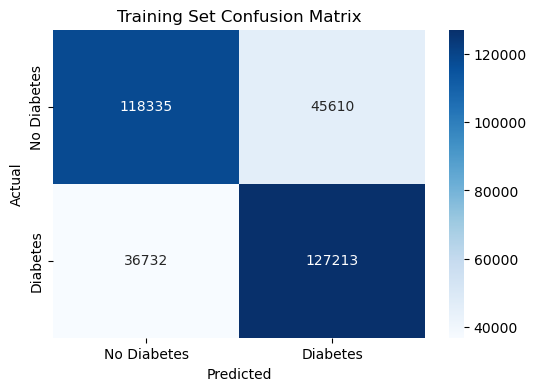

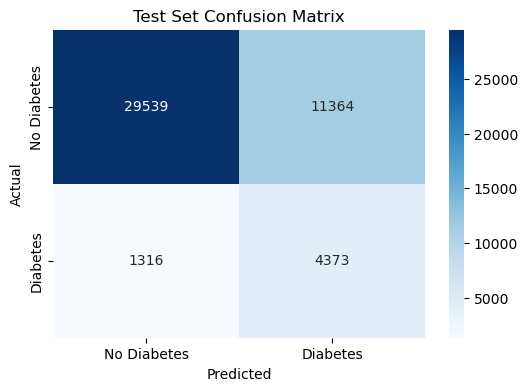

In [ ]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaler, y_train)

model = LogisticRegression(
C=0.0001, penalty='l1', solver='liblinear',class_weight='balanced'
)

model.fit(x_train_resampled, y_train_resampled)

y_train_pred = model.predict(x_train_resampled)
y_test_pred = model.predict(x_test_scaler)

train_accuracy = accuracy_score(y_train_resampled, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

print(classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes']))

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_train_resampled, y_train_pred, "Training Set Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")


### Search For Best Parameters With Cross-Validation focus on Recall in Class 1

In [ ]:
# recall_class1_scorer = make_scorer(
#     recall_score, 
#     pos_label=1,
#     average='binary'
# )

# logistic = LogisticRegression(random_state=42)

# param_grid = [
#     {
#         'penalty': ['l1', 'l2'],
#         'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
#         'solver': ['liblinear', 'saga']
#     },
#     {
#         'penalty': ['l2', 'l1'],
#         'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
#         'class_weight': ['balanced', {0:1, 1:6}], 
#         'solver': ['liblinear', 'saga']
#     }
# ]

# grid_search = GridSearchCV(
#     logistic, 
#     param_grid, 
#     cv=5, 
#     scoring=recall_class1_scorer,
#     n_jobs=-1,
#     verbose=1
# )
# grid_search.fit(x_train_scaler, y_train)

# best_model = grid_search.best_estimator_

# y_pred = best_model.predict(x_test_scaler)

# print("Best Parameters:", grid_search.best_params_)
# print("\nTest Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))


### TEST 2 NOT USE Smothing Focus on Recall

In [ ]:
model_all_features = LogisticRegression(C=0.0001, penalty='l1', solver='liblinear',class_weight='balanced')

model_all_features.fit(x_train_scaler, y_train)

y_train_pred = model_all_features.predict(x_train_scaler)
y_test_pred = model_all_features.predict(x_test_scaler)

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# plot_confusion_matrix(y_train, y_train_pred, "Training Set Confusion Matrix")
# plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred,target_names=['No Diabetes','Diabetes']))

Training Accuracy: 62.27%
Test Accuracy: 62.16%

Classification Report (Test Set):
              precision    recall  f1-score   support

 No Diabetes       0.97      0.59      0.73     40903
    Diabetes       0.23      0.87      0.36      5689

    accuracy                           0.62     46592
   macro avg       0.60      0.73      0.55     46592
weighted avg       0.88      0.62      0.69     46592



### Test 3 Change Threshold

In [ ]:
y_probs = model_all_features.predict_proba(x_test_scaler)[:, 1]
y_train_probs = model_all_features.predict_proba(x_train_scaler)[:, 1]

threshold = 0.4
y_train_pred = (y_train_probs >= threshold).astype(int)
y_test_pred = (y_probs >= threshold).astype(int)


train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Training Accuracy with Threshold {threshold}: {train_accuracy:.2f}%")
print(f"Test Accuracy with Threshold {threshold}: {test_accuracy:.2f}%")

print("\nClassification Report (Test Set) with Threshold =", threshold)
print(classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes']))

Training Accuracy with Threshold 0.4: 45.02%
Test Accuracy with Threshold 0.4: 44.87%

Classification Report (Test Set) with Threshold = 0.4
              precision    recall  f1-score   support

 No Diabetes       0.99      0.38      0.55     40903
    Diabetes       0.18      0.96      0.30      5689

    accuracy                           0.45     46592
   macro avg       0.58      0.67      0.42     46592
weighted avg       0.89      0.45      0.52     46592



### Test 4 Get the top 10 Features

In [ ]:

selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(x_train, y_train)

selected_features = x_train.columns[selector.get_support()]
print("Best features:", selected_features)

Best features: Index(['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity',
       'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Income'],
      dtype='object')


In [ ]:
X_train_selected = selector.transform(x_train)
X_test_selected = selector.transform(x_test)

scaler = StandardScaler()

scaler.fit(X_train_selected)
x_train_scaler = scaler.transform(X_train_selected)
x_test_scaler = scaler.transform(X_test_selected)


model_selected_features = LogisticRegression(C=0.0001, penalty='l1', solver='liblinear',class_weight='balanced')
model_selected_features.fit(x_train_scaler, y_train)

y_train_pred = model_selected_features.predict(x_train_scaler)
y_test_pred = model_selected_features.predict(x_test_scaler)


train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes']))

Training Accuracy: 62.27%
Test Accuracy: 62.16%
              precision    recall  f1-score   support

 No Diabetes       0.97      0.59      0.73     40903
    Diabetes       0.23      0.87      0.36      5689

    accuracy                           0.62     46592
   macro avg       0.60      0.73      0.55     46592
weighted avg       0.88      0.62      0.69     46592

